In [102]:
import io
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import boto3
import sagemaker
from sagemaker import get_execution_role, PCA

In [103]:
session = sagemaker.Session()
print(session)

role = get_execution_role()
print(role)

bucket = session.default_bucket()

arn:aws:iam::240038582877:role/service-role/AmazonSageMaker-ExecutionRole-20191028T202433


### Customers

In [104]:
# load data
prefix = 'segmentation'

data_key= prefix + '/customers_scaled.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [105]:
tmp_list = []

for chunk in pd.read_csv(data_location, chunksize=100000):
    tmp_list.append(chunk)
    
df = pd.concat(tmp_list, axis=0).drop(['Unnamed: 0'], axis=1)
print(df.shape)
del tmp_list

(191652, 94)


In [106]:
df.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.050221,0.75,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.166667,0.833333,0.0,0.833333,1.00,0.666667,0.4,0.0,0.0,0.375
1,0.050232,0.00,0.000000,0.166667,0.555556,0.000000,0.833333,0.000000,1.0,1.000000,...,0.166667,0.333333,0.0,1.000000,1.00,0.666667,0.4,0.0,0.0,0.375
2,0.750693,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.000000,0.166667,0.0,0.333333,0.50,1.000000,0.4,0.0,1.0,0.375
3,0.750698,0.50,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.333333,0.833333,0.5,1.000000,0.25,0.666667,0.0,0.0,0.0,0.375
4,0.750703,0.00,0.166667,0.333333,0.222222,0.714286,0.000000,0.428571,1.0,0.666667,...,0.500000,0.500000,0.5,0.666667,0.50,1.000000,0.0,0.0,0.0,0.250


In [107]:
# prepare space to store model artifacts
prefix = 'pca'
output_path = 's3://{}/{}/'.format(bucket, prefix)
output_path

's3://sagemaker-us-east-2-240038582877/pca/'

In [108]:
N_COMPONENTS = 10
pca = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path=output_path,
          num_components=N_COMPONENTS,
          sagemaker_session=session)

In [109]:
#must convert to RecordSet for built in sagemaker models

#convert df to np array (pass this to the deployed PCA model later)
train_data_np = df.values.astype('float32')

#convert to RecordSet format
formatted_train_data = pca.record_set(train_data_np)

In [110]:
pca.fit(formatted_train_data)

2020-04-12 04:00:39 Starting - Starting the training job...
2020-04-12 04:00:40 Starting - Launching requested ML instances...
2020-04-12 04:01:36 Starting - Preparing the instances for training......
2020-04-12 04:02:21 Downloading - Downloading input data...
2020-04-12 04:03:06 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/12/2020 04:03:08 INFO 140553961531200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/12/2020 04:03:08 INFO 140553961531200] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'94', u'mini_batch_size': u


2020-04-12 04:03:17 Uploading - Uploading generated training model
2020-04-12 04:03:17 Completed - Training job completed
Training seconds: 56
Billable seconds: 56


In [111]:
#get from AWS console
training_job_name = 'pca-2020-04-12-04-00-39-358'
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

pca/pca-2020-04-12-04-00-39-358/output/model.tar.gz


2304

In [112]:
# !pip install mxnet
import mxnet as mx

pca_model_params = mx.ndarray.load('model_algo-1')

print(pca_model_params)

{'s': 
[151.03342 157.1557  158.33104 167.0297  188.32408 193.03432 221.53874
 319.5286  337.85233 675.31635]
<NDArray 10 @cpu(0)>, 'v': 
[[-1.56262788e-04  5.86214568e-03 -3.05910781e-03 -3.08205327e-03
   2.03793729e-03 -1.74974452e-03  1.90320727e-03 -1.34209997e-03
   3.80283134e-04  5.93305740e-04]
 [-2.17574567e-01 -8.72530639e-02 -8.74040574e-02 -2.98052549e-01
  -2.02772513e-01 -1.02115884e-01 -5.94947152e-02  5.77346496e-02
  -1.71816766e-01  1.26919270e-01]
 [-3.37096713e-02  1.10762764e-03 -5.56866499e-03  1.74006075e-02
  -6.07536919e-03  3.93119175e-03  9.00153257e-03 -9.30448368e-05
   2.08125096e-02  9.04781464e-03]
 [-5.92208728e-02  2.44399346e-03 -1.11421598e-02  3.14087532e-02
  -3.81535618e-03  3.66294011e-03  1.41717987e-02 -3.09537500e-05
   3.39998044e-02  1.52490316e-02]
 [ 1.33299515e-01 -1.08833648e-02  3.22222002e-02 -7.29797855e-02
   5.09543018e-03 -6.90436317e-03 -2.31621582e-02  9.35912714e-04
  -7.33822882e-02 -3.87603566e-02]
 [-2.01907605e-01  6.556998

In [113]:
#mean - mean subtracted from a component in order to center it
#v - makeup of the principal component (same as components_)
#s - singular values of the components for the PCA transformation, % of variance from the projected future space

#explained-variance-ratio ~= square(s) / sum(square(s))

s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components

# s = s.apply(lambda x: '%.5f' % x, axis=1)

print(s.iloc[start_idx:])

            0
5  193.034317
6  221.538742
7  319.528595
8  337.852325
9  675.316345


In [114]:
#what is the smallest number or principal comonents that captures at least 80% of the
#total variance in the dataset?

def explained_variance(s, n_top_components):
#     exp_variance = np.square(s.iloc[start_idx:])
    exp_variance = np.square(s.iloc[start_idx:]).sum() / np.square(s).sum()
    return exp_variance

In [115]:
n_top_components = 10
exp_variance = explained_variance(s, n_top_components)
print(exp_variance)

0    0.848037
dtype: float32


### Component Features

In [116]:
df.columns.values;

In [92]:
corr_matrix = df.corr().abs()
c2 = corr_matrix.unstack().sort_values(ascending=False).to_frame()
# set(c2[np.logical_and(c2[0] > 0.8, c2[0] < 1)].index.values)

In [93]:
corr_matrix.style.background_gradient(cmap='coolwarm');

In [94]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
        row_idx = N_COMPONENTS-component_num
        v_l_row = v.iloc[:, row_idx]
        v_1 = np.squeeze(v_l_row.values)
        
        compos = pd.DataFrame(list(zip(v_1, features_list)), columns=['weights', 'features'])
        
        # get absolute value
        #weights can be neg/pos and we'll sort by magnitude
        
        compos['abs_weights'] = compos['weights'].apply(lambda x: abs(x))
        sorted_compos = compos.sort_values('abs_weights', ascending=False).head(n_weights)
        
        ax=plt.subplots(figsize=(10,6))
        ax=sns.barplot(data=sorted_compos, x="weights", y="features", palette="Blues_d")
        ax.set_title("PCA Component Makeup Component #{}".format(component_num))
        plt.show()

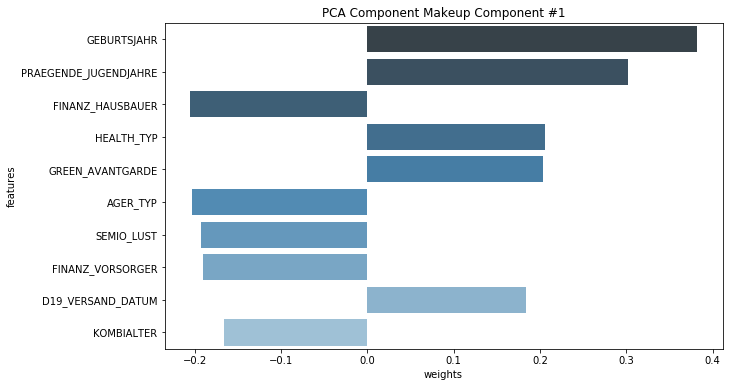

In [95]:
display_component(v, df.columns.values, component_num=1, n_weights=10)

### Deploying the PCA Model

In [117]:
%%time

pca_predictor = pca.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 259 ms, sys: 17.6 ms, total: 277 ms
Wall time: 7min 31s


In [128]:
#try chunking data to PCA endpoint
train_pca = []

for chunk in np.array_split(train_data_np, 120):
    train_pca.append(pca_predictor.predict(chunk))

In [152]:
prefix = 'segmentation'
transformed_pca = session.upload_data('transformed_pca_customer.csv', key_prefix=prefix)